# Investigating Ranks
In the first section, I am going to investigate what an appropriate rank to consider should be. It will make sense to look at the 
ranks of a trained matrix and a randomly initialized matrix. We will start by looking at a randomly initialized matrix and then
look at a trained matrix. Specifically, I will look at the rank of a randomly initialized matrix. I will need to consider the sizes 
that are seen in RoBERTa

## Imports and Helper Functions

In [1]:
# Import Appropriate Libraries
%load_ext autoreload
    
import torch
import matplotlib.pyplot as plt 
from tqdm.notebook import tqdm 
import bisect
import sys
sys.path.append("../")

# Set Logging Level
import logging
level = logging.DEBUG
logging.getLogger("requests").setLevel(level)
logging.getLogger("urllib3").setLevel(level)

In [2]:
def get_principle_direction(A, exp_var):
    U, S, V = torch.linalg.svd(A)
    S = S ** 2
    X = (torch.cumsum(S, 0) / S.sum().item()).tolist()
    num = bisect.bisect(X, exp_var)
    return num

def get_principle_directions(A, exp_vars):
    U, S, V = torch.linalg.svd(A)
    S = S ** 2
    X = (torch.cumsum(S, 0) / S.sum().item()).tolist()
    ret = []
    i, j = 0, 0
    while i < len(exp_vars) and j < len(X):
        val = X[j]
        exp_var = exp_vars[i]
        if val < exp_var:
            j += 1
        else:
            ret.append(j)
            i += 1
    return ret

## Normally Initialized Matrix Analysis

In [3]:
def plot_results(n=100, size=[768, 768], exp_var=0.99):
    results = []
    for _ in range(n):
        A = torch.randn(size)
        num = get_principle_direction(A, exp_var)
        results.append(num)
    return results

(array([18.,  0.,  0.,  0.,  0., 79.,  0.,  0.,  0.,  3.]),
 array([390. , 390.2, 390.4, 390.6, 390.8, 391. , 391.2, 391.4, 391.6,
        391.8, 392. ]),
 <BarContainer object of 10 artists>)

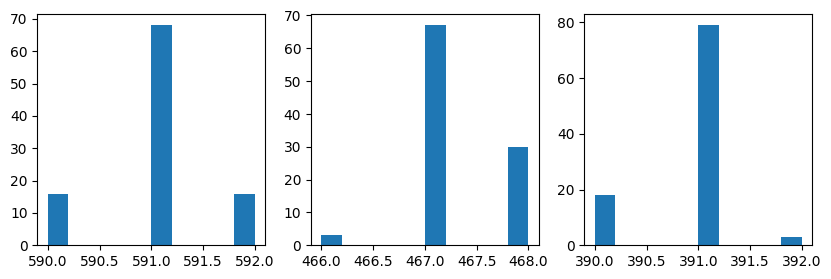

In [4]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 3))
ax[0].hist(plot_results())
ax[1].hist(plot_results(exp_var=0.95))
ax[2].hist(plot_results(exp_var=0.9))

The above results indicate the rank is very tightly distributed based on the explained variance. The reader is encouraged to play with the explained_variance and support the claim themselves.

## Analysis of RoBERTa pre-trained Weights 

In [5]:
## Now let's look at how tightly the weights are distributed in RoBERTa 
from transformers import AutoModelForQuestionAnswering, AutoConfig

In [6]:
# Extract RoBERTa Configuration
roberta_base_config = AutoConfig.from_pretrained('roberta-base')
roberta_large_config = AutoConfig.from_pretrained('roberta-large')

In [7]:
# Extract RoBERTa Model
roberta_base_model = AutoModelForQuestionAnswering.from_config(roberta_base_config)
roberta_large_model = AutoModelForQuestionAnswering.from_config(roberta_large_config)

In [8]:
# Extract Variances for a given set of explained variances
def get_model_principle_direction(model, exp_vars):
    principle_dirs = []
    for key, param in model.named_parameters():
        with torch.no_grad():
            p_size = min(param.size())
            
            if len(param.size()) < 2:
                continue
                
            curr_principle_dirs = get_principle_directions(param, exp_vars)
            curr_principle_dirs = torch.tensor(curr_principle_dirs) / p_size
            
            if torch.any(curr_principle_dirs == 0):
                continue
                
            principle_dirs.append(curr_principle_dirs)
    
    return torch.stack(principle_dirs)

In [9]:
explained_variances = [0.1, 0.3, 0.5, 0.7, 0.9, 0.95, 0.99]
roberta_base_dirs = get_model_principle_direction(roberta_base_model, explained_variances)
roberta_large_dirs = get_model_principle_direction(roberta_large_model, explained_variances)

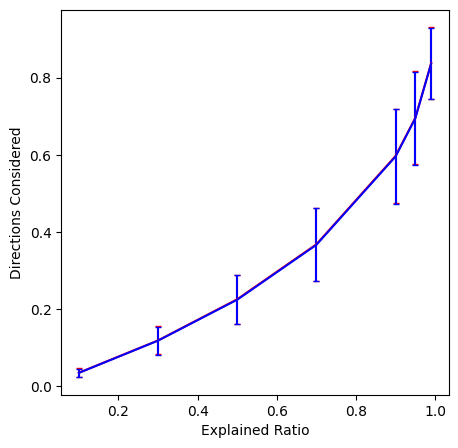

In [10]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
ax.errorbar(explained_variances, roberta_base_dirs.mean(dim=0).tolist(), yerr= roberta_base_dirs.std(dim=0).tolist(), label="RoBERTa Base", color='r', capsize=2)
ax.errorbar(explained_variances, roberta_large_dirs.mean(dim=0).tolist(), yerr= roberta_base_dirs.std(dim=0).tolist(), label="RoBERTa Large", color='b', capsize=2)
ax.set_xlabel("Explained Ratio")
ax.set_ylabel("Directions Considered")
plt.show()

The above results suggest you need most of the directions to account for the explained variance in the parameters.
As such, we finetune the models for SQuAD and review the difference in the weights of the base and the tuned model. If the difference has 
fewer principle directions with high explanation, it would mean it is possible that task-based fine-tuning can be done in a smaller subspace.
Let's add a final touch to the above results by looking at the ratio of number of significant principle directions and all directions.

## Rank Variation During Training

In [11]:
# Get Dataset
import hydra
from omegaconf import DictConfig, OmegaConf
from datasets import load_dataset, load_from_disk
from transformers import AutoTokenizer
from torch.utils.data import DataLoader
from torch.optim import AdamW
from torch.nn import CrossEntropyLoss
from train.train import train_epoch
from utils.metrics import AverageMeter

In [13]:
# Extract Training Configuration
with hydra.initialize(version_base=None, config_path="../config"):
    cfg = hydra.compose(config_name="app_config")

device = 'cuda' if torch.cuda.is_available() else 'cpu'

### Data Analysis

In [14]:
# Process Data
train_dataset = load_dataset("squad", split="train")
val_dataset = load_dataset("squad", split="validation")

# Tokenizer
tokenizer = AutoTokenizer.from_pretrained(cfg.model.name)

#### Training Dataset

In [15]:
print(f"Model Max Length is {tokenizer.model_max_length}")
print(f"Dataset Features are {train_dataset.features}")

Model Max Length is 512
Dataset Features are {'id': Value(dtype='string', id=None), 'title': Value(dtype='string', id=None), 'context': Value(dtype='string', id=None), 'question': Value(dtype='string', id=None), 'answers': Sequence(feature={'text': Value(dtype='string', id=None), 'answer_start': Value(dtype='int32', id=None)}, length=-1, id=None)}


In [16]:
# Columns to Remove
remove_columns=['question', 'context', 'id', 'title']

In [17]:
cut_off_length = 512
long_dataset = train_dataset.filter(lambda x: len(tokenizer(x['question'], x['context']).input_ids) > cut_off_length)
print(f"There are {long_dataset.num_rows} training instances with length longer than {cut_off_length}")

There are 143 training instances with length longer than 512


Since there are only 143 instances with the length longer than 512. I will remove those instances for the purpose of simplicity. These changes are unlikely to affect the outcome. The learned concept will not account for
the cases in which the context may not contain the answer. Also, if there is a regularity in the placement of the answer in the question, the model may over fit to it. But given large number of samples, I assume it is not
the case.

In [18]:
train_dataset = train_dataset.filter(lambda x: len(tokenizer(x['question'], x['context']).input_ids) <= cut_off_length)

In [19]:
## Let's See how the answer looks like
idx = 1
instance = train_dataset[idx]
answer = instance['answers']
print(answer['answer_start'][0])
print(answer['text'])
print(instance['context'][answer['answer_start'][0]:])

188
['a copper statue of Christ']
a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.


In [20]:
# The above indicates the answer_start is the beginning character. Let's see if this is consistent with the rest of the results
char_tokenizer = True
for idx, item in enumerate(train_dataset):
    start = item['answers']['answer_start'][0]
    end = start + len(item['answers']['text'][0])
    extracted_answer = item['context'][start:end]
    answer = item['answers']['text'][0]
    if extracted_answer != answer:
        print(idx, extracted_answer, answer)
    if char_tokenizer:
        tokenized_answer = tokenizer(answer).input_ids
        char_tokenizer = len(tokenized_answer) - 2 == len(answer)

if not char_tokenizer:
    print("Tokenizer is not character based")

Tokenizer is not character based


The above result confirms that the answers are made available in terms of character offset instead of tokenizer offset. This is likely the case to maintain generality. 

In [21]:
def bisect_custom(l, r, tokenizer, tokenized_context, target, l_off=0, r_off=0, mid_off=0):
    # Standard Binary Search with a Few Bells and Whistles
    while l < r:
        mid = l + (r - l + mid_off) // 2
        partial_context = tokenizer.decode(tokenized_context[:mid])
        if len(partial_context) <= target:
            l = mid + l_off
        else:
            r = mid + r_off
        # print(r, l, mid)
    return max(l, r)

def get_start_end_index(tokenized_context, answer, answer_start):
    # Set Answer End Index
    answer_end = answer_start + len(answer)

    # Search for the starting index of the Token That contains the answer
    ll, rl = 0, len(tokenized_context)
    # print("Starting Left Search")
    start_index = bisect_custom(ll, rl, tokenizer, tokenized_context, answer_start, r_off=-1, mid_off=1)

    # Search for the ending index of the tokens in which the answer terminates
    rl, rr = start_index, len(tokenized_context)
    # print("Starting Right Search")
    end_index = bisect_custom(start_index, len(tokenized_context), tokenizer, tokenized_context, answer_end, l_off=1)
    
    return start_index, end_index

def validate(tokenized_context, start_index, end_index, idx, answer, context, question, ret):
    # Test if the correct Solution is found by extracting the partial context and checking if the answer is contained.
    # While this is not a 100% foolproof solution. Informal tests before confirmed this to be the case.
    # You can set the extracted_answers char offset to answer_start
    extracted_context = tokenized_context[start_index:end_index]
    extracted_answer = tokenizer.decode(extracted_context).strip()
    
    if extracted_answer.find(answer) == -1:
        failed_instance = {"idx" : idx, 
                           "start_index" : start_index,
                           "end_index" : end_index,
                           "extracted_answer" : extracted_answer,
                           "answer" : answer,
                           "context" : context,
                           "question" : question} 
        ret.append(failed_instance)

In [22]:
# Let's tokenize the start and end character
failed_indices = []
for idx, item in tqdm(enumerate(train_dataset)):
    question = item['question']
    context = item['context']
    
    answer = item['answers']['text'][0]
    answer_start = item['answers']['answer_start'][0]

    # Extract Start and End Index of the Tokenized Question/Context Duo
    tokenized_question = tokenizer(question).input_ids
    tokenized_context = tokenizer(question, context).input_ids
    start_index, end_index = get_start_end_index(tokenized_context, answer, answer_start + len(question) + 10)

    # Test if the correct Solution is found
    validate(tokenized_context, start_index, end_index, idx, answer, context, question, failed_indices)

0it [00:00, ?it/s]

In [23]:
print(fr"There are {len(failed_indices)} failed instances by the above method") 

There are 71 failed instances by the above method


In [24]:
map_failed_instances = []

def process_batched_training_examples(instances):
    questions, contexts = instances['question'], instances['context']
    answers = instances['answers']
    
    inputs = tokenizer(questions, contexts) # Batched Tokenization
    start_index, end_index = [], [] # Store the start and end_index in the beginning
    
    for idx, instance in enumerate(instances['id']):
        answer_text, answer_start = answers[idx]['text'][0], answers[idx]['answer_start'][0]

        start, end = get_start_end_index(inputs.input_ids[idx], answer_text, answer_start + len(questions[idx]) + 10)
        
        start_index.append(start)
        end_index.append(end)

        # Result Validation and storing the ones that failed. - map failed instances must be cleared every time to avoid accumulation
        validate(inputs.input_ids[idx], start, end, 0, answer_text, contexts[idx], questions[idx], map_failed_instances)

    inputs['start_positions'] = start_index
    inputs['end_positions'] = end_index

    return inputs

def process_training_examples(instance):
    
    question, context = instance['question'], instance['context']
    answer = instance['answers']
    
    inputs = tokenizer(question, context)
    
    answer_text, answer_start = answer['text'][0], answer['answer_start'][0]

    start_index, end_index = get_start_end_index(inputs.input_ids, answer_text, answer_start + len(question) + 10)
    
    inputs['start_positions'] = start_index
    inputs['end_positions'] = end_index

    # Result Validation and storing the ones that failed. - map failed instances must be cleared every time to avoid accumulation
    validate(inputs.input_ids, start_index, end_index, 0, answer_text, context, question, map_failed_instances)

    return inputs

In [25]:
train_dataset = train_dataset.map(
    process_batched_training_examples,
    batched=True,
    remove_columns=remove_columns
)

In [26]:
train_dataset.save_to_disk("../data/squad")

Saving the dataset (0/1 shards):   0%|          | 0/87456 [00:00<?, ? examples/s]

#### Validation Dataset

In [27]:
val_dataset.filter(lambda x: len(x['answers']) > 1)

Dataset({
    features: ['id', 'title', 'context', 'question', 'answers'],
    num_rows: 10570
})

In [28]:
val_dataset = val_dataset.filter(lambda x: len(tokenizer(x['question'], x['context']).input_ids) <= cut_off_length)

In [29]:
def process_validation_examples(instances):
    questions, contexts = instances['question'], instances['context']
    inputs = tokenizer(questions, contexts) # Batched Tokenization
    return inputs

In [30]:
val_dataset = val_dataset.map(
    process_validation_examples,
    batched=True,
    remove_columns=remove_columns
)

In [31]:
print(val_dataset[0].keys())

dict_keys(['answers', 'input_ids', 'attention_mask'])


### Training

In [32]:
from torch.nn.utils.rnn import pad_sequence
from collections import defaultdict
pad_keys = ['input_ids', 'attention_mask']
stack_keys = [ 'start_positions', 'end_positions']
pad_id = tokenizer.pad_token_id

def collate_fn(batch):
    tensor_batch = defaultdict(list)
        
    # Generate list of samples in batch
    for sample in batch:
        for key in pad_keys + stack_keys:
            key_tensor = torch.tensor(sample[key])
            tensor_batch[key].append(key_tensor)

    # padding value of attention_mask is 0 since it is multiplied
    tensor_batch['input_ids'] = pad_sequence(tensor_batch['input_ids'], padding_value=pad_id, batch_first=True)
    tensor_batch['attention_mask'] = pad_sequence(tensor_batch['attention_mask'], padding_value=0, batch_first=True)
    
    for key in stack_keys:
        tensor_batch[key] = torch.stack(tensor_batch[key])

    for k, v in tensor_batch.items():
        tensor_batch[k] = v.to(device)

    return tensor_batch

In [33]:
# Tensors for Gradient Accumulation
def get_grad_principle_directions(gradient_dictionary, exp_vars):
    exp_dirs = []
    for key, val in gradient_dictionary.items():
        
        if min(val.size()) < 2:
            continue

        curr_dirs = get_principle_directions(val, exp_vars)
        curr_dirs = torch.tensor(curr_dirs) / min(val.size())

        exp_dirs.append(curr_dirs)
    return torch.stack(exp_dirs)
        

class GradAccumulator:
    """
    """
    def __init__(self, model):
        
        self.model = model
        self.accumulator = self.init_grad()
    
    def init_grad(self):
        accumulator = dict()
        for name, param in self.model.named_parameters():
            if len(param.size()) < 2:
                continue
                
            accumulator[name] = torch.zeros_like(param, requires_grad=False)
    
        return accumulator

    def accumulate_grad(self):
        for name, param in self.model.named_parameters():
            if name in self.accumulator:
                self.accumulator[name] += param.grad

    def reset(self):
        for key in self.accumulator.keys():
            self.accumulator[key] = 0

    def analyze_grad(self, exp_vars):
        # Move to CPU
        for key in self.accumulator.keys():
            self.accumulator[key] = self.accumulator[key].cpu()
        exp_dirs = get_grad_principle_directions(self.accumulator, exp_vars)
        return exp_dirs.mean(dim=0), exp_dirs.std(dim=0)

In [34]:
## Create Training Artifacts
training_cfg = hydra.utils.instantiate(cfg.model.model.train)

train_loader = DataLoader(train_dataset, batch_size=training_cfg.batch_size, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=training_cfg.batch_size)

model = roberta_base_model if cfg.model.name == 'roberta-base' else roberta_large_model
model.to(device)
optimizer = AdamW(params=model.parameters(), lr=training_cfg.lr, weight_decay=training_cfg.weight_decay)
criterion = CrossEntropyLoss()

loss_meter = AverageMeter()
acc_meter = AverageMeter()
accumulator = GradAccumulator(model)

In [35]:
# Initialize ML Flow
import mlflow

# Set Tracking URI
uri = mlflow.get_tracking_uri()
if uri is None or uri != "http://127.0.0.1:8080":
    mlflow.set_tracking_uri("http://127.0.0.1:8080")

# Set Experiment
experiment_name = f"{cfg.model.name}-{cfg.dataset.name}"
exps = mlflow.search_experiments(filter_string=f"name='{experiment_name}'")

if len(exps) == 0:
    experiment_id = mlflow.create_experiment(experiment_name)
else:
    experiment_id = exps[0].experiment_id

In [ ]:
# Training Loop
progress_bar = tqdm(total=training_cfg.epochs * len(train_loader))
with mlflow.start_run(experiment_id=experiment_id, run_name=experiment_name) as run:
    for epoch in range(training_cfg.epochs):
        for i, batch in enumerate(train_loader):
            # Reset Optimizer to 0
            optimizer.zero_grad()
        
            # Forward Pass
            output = model(**batch)
        
            # Backward Pass
            output.loss.backward()
            optimizer.step()

            # Accumulate Gradient
            accumulator.accumulate_grad()
            
            # Evaluate Performance
            start_position_pred = torch.argmax(output.start_logits, dim=1)
            end_position_pred = torch.argmax(output.end_logits, dim=1)
            correct_exact_matches = ((batch["start_positions"] == start_position_pred) 
                                     & (batch["end_positions"] == end_position_pred)).sum()
            
            # Update Meters
            acc_meter.update(correct_exact_matches.item(), len(batch))
            loss_meter.update(output.loss.item(), 1)

            # Update Progress
            progress_bar.update(1)

        
        # Compute Metrics
        match_accuracy = acc_meter.average()
        training_loss = loss_meter.average()
        mean_dirs, std_dirs = accumulator.analyze_grad(explained_variances)

        # Reset Accumulator
        accumulator.reset()
        
        
        # Track Metrics
        mlflow.log_metric("training match accuracy", match_accuracy, step=epoch)
        mlflow.log_metric("training loss", training_loss, step=epoch)
        
        for i, exp_var in enumerate(explained_variances):
            mlflow.log_metric(f"Mean Principle Dir Ratio {exp_var}", mean_dirs[i], step=epoch)
            mlflow.log_metric(f"Std Dev Principle Dir Ratio {exp_var}", std_dirs[i], step=epoch)

  0%|          | 0/54660 [00:00<?, ?it/s]

In [ ]:
param = None
for params in model.parameters():
    param = params
    break

In [51]:
from torchviz import make_dot

In [57]:
start_position = torch.argmax(output.start_logits, dim=1)
end_position = torch.argmax(output.end_logits, dim=1)

In [63]:
((batch["start_positions"] == start_position) 
 & (batch["end_positions"] == end_position)).sum()

tensor(0)

In [18]:
for item in train_dataset:
    x = f"[CLS]{item['question']}[SEP]{item['context']}"
    tokenized_x = tokenizer(item['question'], item['context'])
    print(tokenized_x)
    break

{'input_ids': [0, 3972, 2661, 222, 5, 9880, 2708, 2346, 2082, 11, 504, 4432, 11, 226, 2126, 10067, 1470, 116, 2, 2, 37848, 37471, 28108, 6, 5, 334, 34, 10, 4019, 2048, 4, 497, 1517, 5, 4326, 6919, 18, 1637, 31346, 16, 10, 9030, 9577, 9, 5, 9880, 2708, 4, 29261, 11, 760, 9, 5, 4326, 6919, 8, 2114, 24, 6, 16, 10, 7621, 9577, 9, 4845, 19, 3701, 62, 33161, 19, 5, 7875, 22, 39043, 1459, 1614, 1464, 13292, 4977, 845, 4130, 7, 5, 4326, 6919, 16, 5, 26429, 2426, 9, 5, 25095, 6924, 4, 29261, 639, 5, 32394, 2426, 16, 5, 7461, 26187, 6, 10, 19035, 317, 9, 9621, 8, 12456, 4, 85, 16, 10, 24633, 9, 5, 11491, 26187, 23, 226, 2126, 10067, 6, 1470, 147, 5, 9880, 2708, 2851, 13735, 352, 1382, 7, 6130, 6552, 625, 3398, 208, 22895, 853, 1827, 11, 504, 4432, 4, 497, 5, 253, 9, 5, 1049, 1305, 36, 463, 11, 10, 2228, 516, 14, 15230, 149, 155, 19638, 8, 5, 2610, 25336, 238, 16, 10, 2007, 6, 2297, 7326, 9577, 9, 2708, 4, 2], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [ ]:
logits = model.forward

### Evaluation

# Introducing LoRA Weights
This section introduces LoRA weights in our models for further analysis.

In [3]:
# On the surface the above results suggest you need most of the directions to account for most of the directions. 
# It will be useful to see which directions are affected and how later.
from models.LoRA import LoRALinearLayer
def add_linear_lora(module, rank, init_type=0):
    for key, child in module.named_children():
        if isinstance(child, torch.nn.Linear):
            lora_layer =  LoRALinearLayer(child, rank=rank, init_type=init_type)
            setattr(module, key, lora_layer)
        else:
            add_linear_lora(child, rank, init_type)

In [4]:
add_linear_lora(roberta_base, rank=10, init_type=1)

In [5]:
roberta_base

RobertaHubInterface(
  (model): RobertaModel(
    (encoder): RobertaEncoder(
      (sentence_encoder): TransformerEncoder(
        (dropout_module): FairseqDropout()
        (embed_tokens): Embedding(50265, 768, padding_idx=1)
        (embed_positions): LearnedPositionalEmbedding(514, 768, padding_idx=1)
        (layernorm_embedding): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (layers): ModuleList(
          (0-11): 12 x TransformerEncoderLayerBase(
            (self_attn): MultiheadAttention(
              (dropout_module): FairseqDropout()
              (k_proj): LoRALinear(in_features=768, in_features=768, rank=$10, init_type=$1)
              (v_proj): LoRALinear(in_features=768, in_features=768, rank=$10, init_type=$1)
              (q_proj): LoRALinear(in_features=768, in_features=768, rank=$10, init_type=$1)
              (out_proj): LoRALinear(in_features=768, in_features=768, rank=$10, init_type=$1)
            )
            (self_attn_layer_norm): LayerNorm

In [6]:
roberta_large

RobertaHubInterface(
  (model): RobertaModel(
    (encoder): RobertaEncoder(
      (sentence_encoder): TransformerEncoder(
        (dropout_module): FairseqDropout()
        (embed_tokens): Embedding(50265, 1024, padding_idx=1)
        (embed_positions): LearnedPositionalEmbedding(514, 1024, padding_idx=1)
        (layernorm_embedding): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (layers): ModuleList(
          (0-23): 24 x TransformerEncoderLayerBase(
            (self_attn): MultiheadAttention(
              (dropout_module): FairseqDropout()
              (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
            )
            (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
       

In [47]:
from transformers import AutoTokenizer, AutoModel, AutoConfig

In [48]:
model_config = AutoConfig.from_pretrained('roberta-base')

DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /roberta-base/resolve/main/config.json HTTP/1.1" 200 0


In [49]:
model = AutoModel.from_config(model_config)